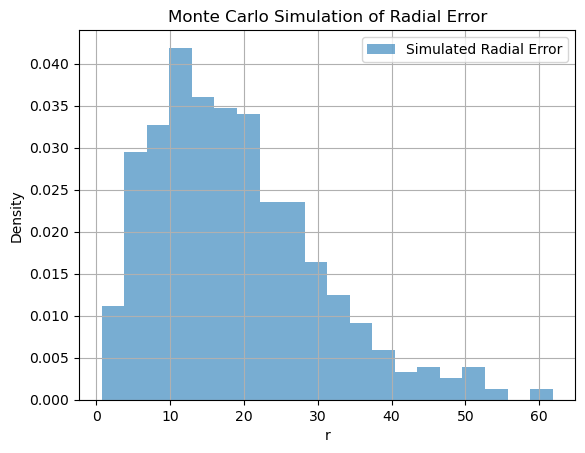

In [8]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..")))
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh
from radial_error.simulation import simulate_radial_error

N_SAMPLES = 500
N_BINS = int(N_SAMPLES/25)
SIGMA_X = 10
SIGMA_Y = 20
RADIAL_CUTOFF = 50

r = simulate_radial_error(n_samples=N_SAMPLES, seed=0, sigma_x = SIGMA_X, sigma_y = SIGMA_Y)

plt.hist(r, bins=N_BINS, density=True, alpha=0.6, label="Simulated Radial Error")

if SIGMA_X == 0 and SIGMA_Y == 0:
    x = np.linspace(0, np.max(r), N_BINS)
    plt.plot(x, rayleigh.pdf(x, scale=1), linestyle='--', label='Rayleigh PDF')

plt.title("Monte Carlo Simulation of Radial Error")
plt.xlabel("r")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


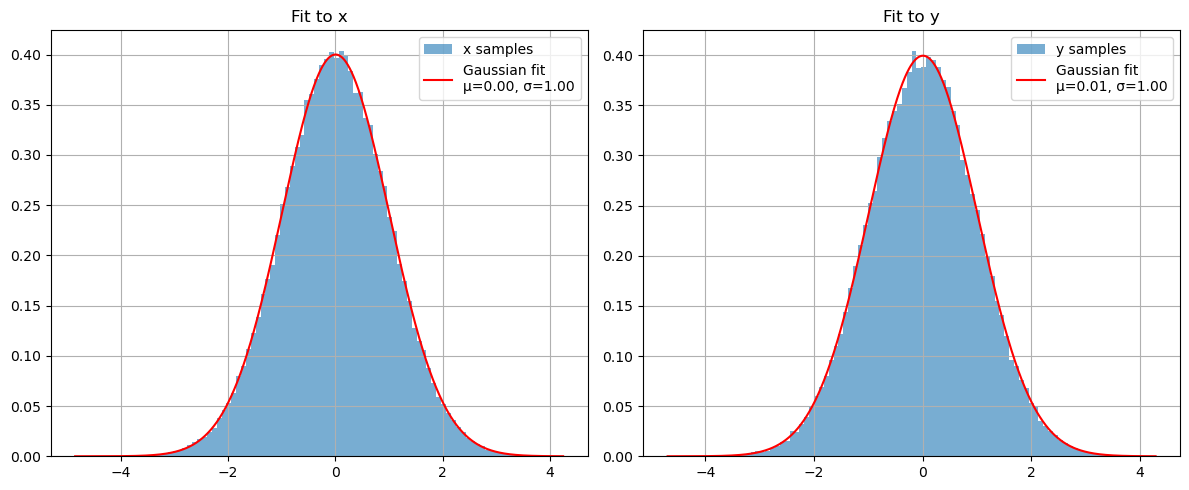

95% Confidence Interval for μ (x): [-0.005, 0.008]
95% Confidence Interval for σ (x): [0.993, 1.002]
95% Prediction Interval for new x: [-1.953, 1.956]
Approximate 99% Tolerance Interval: [-2.567, 2.571]


In [13]:
from scipy.stats import norm, t, chi2

from math import sqrt

# Fit Gaussian
mu_x, sigma_x = norm.fit(x)
mu_y, sigma_y = norm.fit(y)
# Plot histogram + fit for x
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=100, density=True, alpha=0.6, label="x samples")
x_line = np.linspace(min(x), max(x), 1000)
plt.plot(x_line, norm.pdf(x_line, mu_x, sigma_x), 'r-', label=f'Gaussian fit\nμ={mu_x:.2f}, σ={sigma_x:.2f}')
plt.title("Fit to x")
plt.legend()
plt.grid(True)

# Plot histogram + fit for y
plt.subplot(1, 2, 2)
plt.hist(y, bins=100, density=True, alpha=0.6, label="y samples")
y_line = np.linspace(min(y), max(y), 1000)
plt.plot(y_line, norm.pdf(y_line, mu_y, sigma_y), 'r-', label=f'Gaussian fit\nμ={mu_y:.2f}, σ={sigma_y:.2f}')
plt.title("Fit to y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

n = len(x)
alpha = 0.05  # for 95% intervals
confidence = 1 - alpha
t_crit = t.ppf(1 - alpha/2, df=n - 1)
ci_low = mu_x - t_crit * sigma_x / sqrt(n)
ci_high = mu_x + t_crit * sigma_x / sqrt(n)

# chi-squared critical values
df = n - 1
chi2_low = chi2.ppf(alpha / 2, df)
chi2_high = chi2.ppf(1 - alpha / 2, df)

# Confidence interval for σ
ci_sigma_low = sqrt((df * sigma_x**2) / chi2_high)
ci_sigma_high = sqrt((df * sigma_x**2) / chi2_low)

print(f"95% Confidence Interval for μ (x): [{ci_low:.3f}, {ci_high:.3f}]")
print(f"95% Confidence Interval for σ (x): [{ci_sigma_low:.3f}, {ci_sigma_high:.3f}]")

pred_low = mu_x - t_crit * sigma_x * sqrt(1 + 1/n)
pred_high = mu_x + t_crit * sigma_x * sqrt(1 + 1/n)

print(f"95% Prediction Interval for new x: [{pred_low:.3f}, {pred_high:.3f}]")
confidence_level = 0.95
coverage = 0.99  # 99% of the population
z = norm.ppf((1 + coverage) / 2)  # e.g., z = 2.576 for 99% coverage
tol_low = mu_x - z * sigma_x
tol_high = mu_x + z * sigma_x

print(f"Approximate 99% Tolerance Interval: [{tol_low:.3f}, {tol_high:.3f}]")




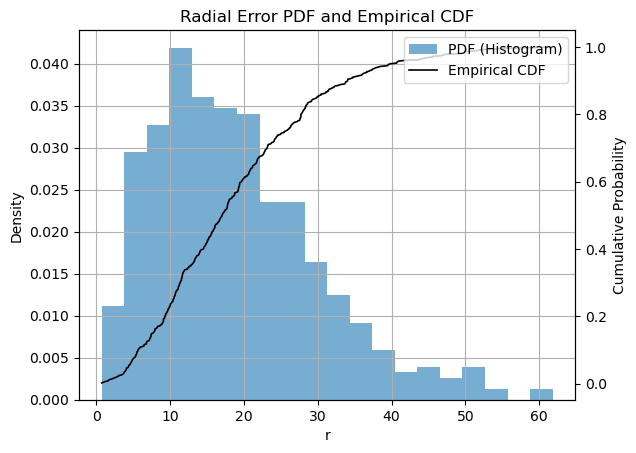

In [2]:
# Histogram
fig, ax1 = plt.subplots()

counts, bins, _ = ax1.hist(r, bins=N_BINS, density=True, alpha=0.6, label="PDF (Histogram)")
ax1.set_xlabel("r")
ax1.set_ylabel("Density")
ax1.grid(True)

# CDF
ax2 = ax1.twinx()
sorted_r = np.sort(r)
cdf = np.arange(1, len(r)+1) / len(r)
ax2.plot(sorted_r, cdf, color='black', linewidth=1.2, label="Empirical CDF")
ax2.set_ylabel("Cumulative Probability")

# Legends and title
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Radial Error PDF and Empirical CDF")
plt.show()


In [3]:
fraction_exceeding_50 = np.mean(r > 50)
print(f"Fraction of samples with r > 50: {fraction_exceeding_50:.5f}")


Fraction of samples with r > 50: 0.01600


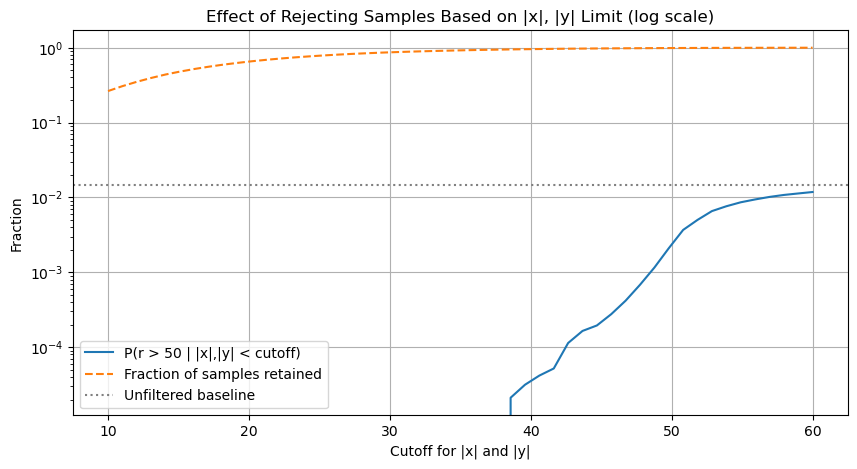

In [4]:
from radial_error.simulation import sample_xy, compute_radial_error

x, y = sample_xy(n_samples=100000, seed=0,sigma_x = SIGMA_X, sigma_y = SIGMA_Y)
r = compute_radial_error(x, y)

cutoffs = np.linspace(10, RADIAL_CUTOFF+int(0.2*RADIAL_CUTOFF), RADIAL_CUTOFF)
fractions_above_cutoff = []
fractions_retained = []

for c in cutoffs:
    mask = (np.abs(x) <= c) & (np.abs(y) <= c)
    r_filtered = r[mask]
    
    if len(r_filtered) == 0:
        fractions_above_cutoff.append(np.nan)
        fractions_retained.append(0)
    else:
        frac_high_r = np.mean(r_filtered > RADIAL_CUTOFF)
        fractions_above_cutoff.append(frac_high_r)
        fractions_retained.append(len(r_filtered) / len(r))

# Plot: Fraction of retained samples with r > 50 vs cutoff
plt.figure(figsize=(10, 5))
plt.plot(cutoffs, fractions_above_cutoff, label="P(r > "+str(RADIAL_CUTOFF)+" | |x|,|y| < cutoff)")
plt.plot(cutoffs, fractions_retained, label="Fraction of samples retained", linestyle="--")
plt.axhline(np.mean(r > RADIAL_CUTOFF), color='gray', linestyle=':', label="Unfiltered baseline")
plt.xlabel("Cutoff for |x| and |y|")
plt.ylabel("Fraction")
plt.yscale("log")  # <-- Log scale here
plt.title("Effect of Rejecting Samples Based on |x|, |y| Limit (log scale)")
plt.legend()
plt.grid(True)
plt.show()

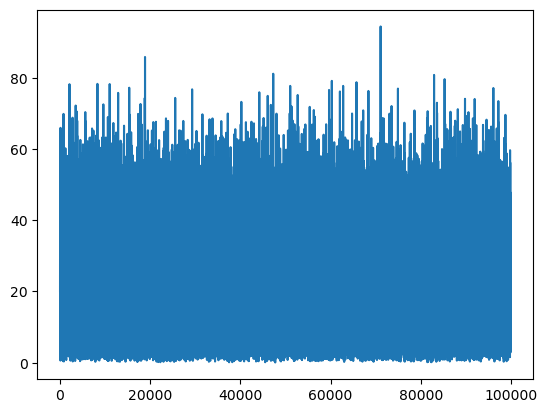

In [5]:
plt.plot(np.arange(0,len(r)),r)
plt.show()

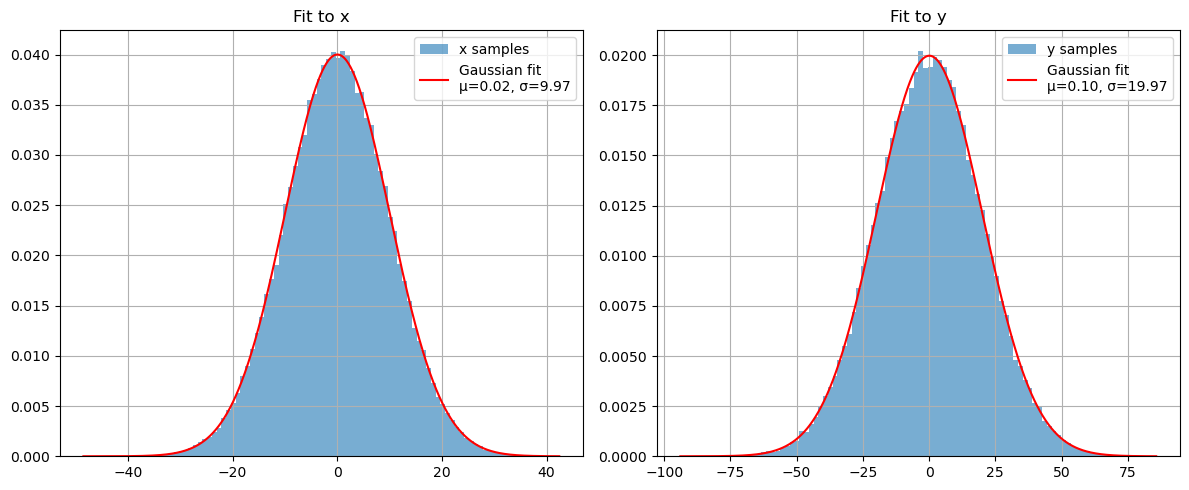

In [7]:
from radial_error.simulation import sample_xy
from radial_error.stats import analyze_distribution

x, y = sample_xy(n_samples=100000, seed=0)

analyze_distribution(x, name="x")
analyze_distribution(y, name="y")

--- Analysis of x ---
Skewness: -0.008 (approximately symmetric)
Kurtosis: 0.031 (normal-tailed)
Conclusion: Gaussian-like. Gaussian fit likely appropriate.
--- Analysis of y ---
Skewness: 0.006 (approximately symmetric)
Kurtosis: 0.000 (normal-tailed)
Conclusion: Gaussian-like. Gaussian fit likely appropriate.
